# Digital Image Processing - Assignment 3
### Laksh Nanwani - 2021701002 - MS CSE - laksh.nanwani@research.iiit.ac.in

---

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
def readRgbImage(name):
    return cv2.cvtColor(cv2.imread("../images/" + name), cv2.COLOR_BGR2RGB)

In [3]:
def readGrayImage(name):
    return cv2.cvtColor(cv2.imread("../images/" + name), cv2.COLOR_BGR2GRAY)

# 1
__1. Implement a function medianFilter which takes in an RGB image im, filter size k
and use it for the image NoisySimba.png and report the output.__

In [4]:
from sortedcontainers import SortedList

In [5]:
def efficient_median_filter(img, k, zero_padding = 0):
    in_img = np.zeros((img.shape[0] + 2 * zero_padding, img.shape[1] + 2 * zero_padding), int)
    in_img[zero_padding : in_img.shape[0] - zero_padding, zero_padding : in_img.shape[1] - zero_padding] = img
    
    new_h, new_w = (in_img.shape[0] - k + 1), (in_img.shape[1] - k + 1)
    
    new_img = np.zeros((new_h, new_w), int)

    median_along_row = np.zeros((in_img.shape[0], new_w))
    
    isEven = (k % 2 == 0)
    mid = k//2
    midnext = mid-1
    # row wise median
    
    for i in range(median_along_row.shape[0]):
        s = SortedList(in_img[i, 0:k])
        if isEven:
            median_along_row[i,0] = (s[mid] + s[midnext])/2
        else:
            median_along_row[i,0] = s[mid]
            
        for j in range(1, median_along_row.shape[1]):
            s.discard(in_img[i, j-1])
            s.add(in_img[i, j+k-1])
            if isEven:
                median_along_row[i,j] = (s[mid] + s[midnext]) / 2
            else:
                median_along_row[i,j] = s[mid]
        s.clear()
    
    # column wise median
    for j in range(new_w):
        s = SortedList(median_along_row[0:k, j])
        if isEven:
            new_img[0,j] = (s[mid] + s[midnext]) / 2
        else:
            new_img[0,j] = s[mid]
            
        for i in range(1, new_h):
            s.discard(median_along_row[i-1, j])
            s.add(median_along_row[i+k-1, j])
            new_img[i,j] = s[mid]
            if isEven:
                new_img[i,j] = (s[mid] + s[midnext]) / 2
            else:
                new_img[i,j] = s[mid]
        s.clear()

    return new_img

In [6]:
def rgb_median_filter(im, k, zero_padding = 0):
    new_h, new_w = (im.shape[0] + 2 * zero_padding - k + 1), (im.shape[1] + 2 * zero_padding - k + 1)
    new_img = np.zeros((new_h, new_w, 3), np.uint8)
    
    for i in range(3):
        new_img[:,:,i] = efficient_median_filter(im[:,:,i], k, zero_padding)
        
    return new_img

In [7]:
noisySimba = readRgbImage("NoisySimba.png")

In [8]:
medianSimba = rgb_median_filter(noisySimba, 5)

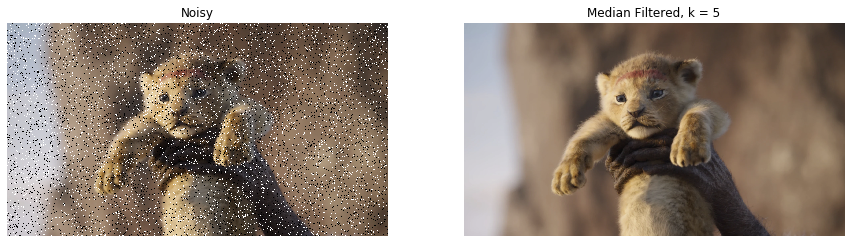

In [9]:
fig1, axes1 = plt.subplots(1,2, figsize = (15,10))

axes1[0].imshow(noisySimba)
axes1[0].axis('off')
axes1[0].set_title('Noisy')

axes1[1].imshow(medianSimba)
axes1[1].axis('off')
axes1[1].set_title('Median Filtered, k = 5')

plt.show()

k = 5 gives the a nice noise free output

__2. Write a function colorLinContrastStretching which takes an image im as in-
put and returns a contrast-enhanced version of the image. Apply the function on
fog.jpeg and display your result.__

In [10]:
def linContrastStretchingSingleChannel(img, a, b):
    low_intensity = img.min()
    high_intensity = img.max()
    constant_factor = (b-a) / (high_intensity - low_intensity)
    return (a + (img - low_intensity) * constant_factor)

def colorLinContrastStretching(im, a, b):
    out_im = np.zeros(im.shape, np.uint8)
    for channel in range(3):
        out_im[:,:,channel] = linContrastStretchingSingleChannel(im[:,:,channel], a, b)
    return out_im

In [11]:
fog_image = readRgbImage("fog.jpeg")

In [12]:
fog_linContrast = colorLinContrastStretching(fog_image, 0, 255)

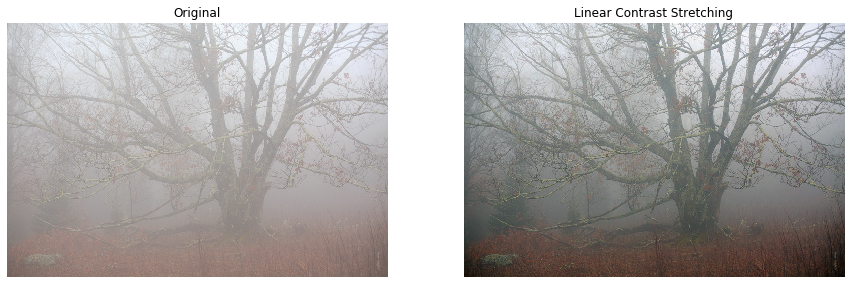

In [13]:
fig1, axes1 = plt.subplots(1,2, figsize = (15,10))

axes1[0].imshow(fog_image)
axes1[0].axis('off')
axes1[0].set_title('Original')

axes1[1].imshow(fog_linContrast)
axes1[1].axis('off')
axes1[1].set_title('Linear Contrast Stretching')

plt.show()

__3. Perform histogram equalization on the image fog.jpeg and show the result.__

In [14]:
# per channel
def get_new_intensities_per(img):
    new_intensities = np.zeros(256)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_intensities[img[i][j]] += 1
    
    for i in range(1,256):
        new_intensities[i] = new_intensities[i] + new_intensities[i-1]
        
    pixel_count = (img.shape[0] * img.shape[1])
    return (np.round(255 * new_intensities / pixel_count, 0)).astype(int)   # round(255 * pdf)

def colorHistEqualizationPer(img):
    out_img = img.copy()
    for i in range(3):
        new_intensities = get_new_intensities_per(img[:,:,i])
        out_img[:,:,i] = new_intensities[img[:,:,i]]
    return out_img

In [15]:
# all channels together
def get_new_intensities_all(img):
    new_intensities = np.zeros(256)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(3):
                new_intensities[img[i][j][c]] += 1
    
    for i in range(1,256):
        new_intensities[i] = new_intensities[i] + new_intensities[i-1]
        
    pixel_count = (img.shape[0] * img.shape[1] * 3)
    return (np.round(255 * new_intensities / pixel_count, 0)).astype(int)   # round(255 * pdf)

def colorHistEqualizationAll(img):
    new_intensities = get_new_intensities_all(img)
    return new_intensities[img]

In [16]:
fog_image = readRgbImage("fog.jpeg")

In [17]:
fog_histEqual_per = colorHistEqualizationPer(fog_image)

In [18]:
fog_histEqual_all = colorHistEqualizationAll(fog_image)

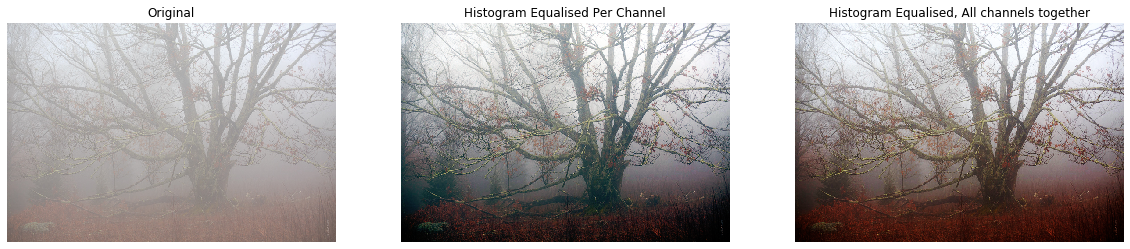

In [19]:
fig1, axes1 = plt.subplots(1,3, figsize = (20,10))

axes1[0].imshow(fog_image)
axes1[0].axis('off')
axes1[0].set_title('Original')

axes1[1].imshow(fog_histEqual_per)
axes1[1].axis('off')
axes1[1].set_title('Histogram Equalised Per Channel')

axes1[2].imshow(fog_histEqual_all)
axes1[2].axis('off')
axes1[2].set_title('Histogram Equalised, All channels together')

plt.show()

__4. Demonstrate ”Vintage effect”, ”Matrix effect”, Vignetting and duo-tone on any
image of your choice.
Note: You are allowed to use cv2.LUT() for duo-tone.__

In [20]:
parrot = readRgbImage("parrot.jpg")

In [21]:
def vintage(im):
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    
    out_img = np.zeros(im.shape)
    out_img[:,:,0] = 0.293 * r + 0.769 * g + 0.210 * b
    out_img[:,:,1] = 0.249 * r + 0.686 * g + 0.188 * b
    out_img[:,:,2] = 0.172 * r + 0.534 * g + 0.151 * b
    
    out_img[out_img > 255] = 255
    return out_img.astype('uint8')

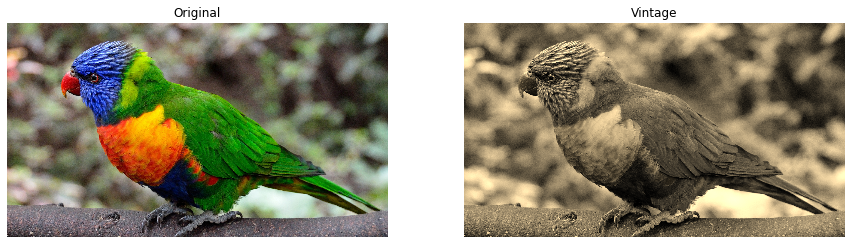

In [22]:
fig1, axes1 = plt.subplots(1,2, figsize = (15,10))

axes1[0].imshow(parrot)
axes1[0].axis('off')
axes1[0].set_title('Original')

axes1[1].imshow(vintage(parrot))
axes1[1].axis('off')
axes1[1].set_title('Vintage')

plt.show()

In [23]:
def matrix(im):
    out_img = im / 255
#     out_img = np.zeros(im.shape)
    out_img[:,:,0] = np.power(out_img[:,:,0], 3/2)
    out_img[:,:,1] = np.power(out_img[:,:,1], 4/5)
    out_img[:,:,2] = np.power(out_img[:,:,2], 3/2)
    
    out_img *= 255
    return out_img.astype('uint8')

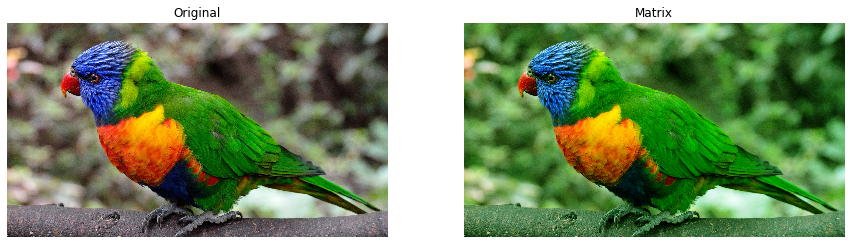

In [24]:
fig1, axes1 = plt.subplots(1,2, figsize = (15,10))

axes1[0].imshow(parrot)
axes1[0].axis('off')
axes1[0].set_title('Original')

axes1[1].imshow(matrix(parrot))
axes1[1].axis('off')
axes1[1].set_title('Matrix')

plt.show()

In [25]:
def vignetting(img, sigma):
    h, w = img.shape[0:2]
    kernel_x = cv2.getGaussianKernel(w, sigma)
    kernel_y = cv2.getGaussianKernel(h, sigma)
    kernel = kernel_y * kernel_x.T
    kernel /= np.max(kernel)
    
    if len(img.shape) == 2:
        return img * kernel
    
    out = np.copy(img).astype(np.uint8)
    for i in range(3):
        out[:,:,i] = out[:,:,i] * kernel
        
    return out
#     pass

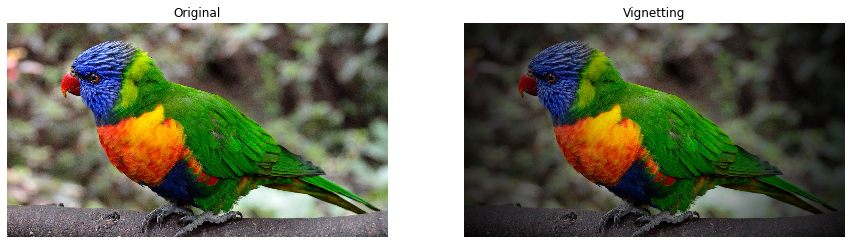

In [26]:
fig1, axes1 = plt.subplots(1,2, figsize = (15,10))

axes1[0].imshow(parrot)
axes1[0].axis('off')
axes1[0].set_title('Original')

axes1[1].imshow(vignetting(parrot, 1100), cmap = 'gray')
axes1[1].axis('off')
axes1[1].set_title('Vignetting')

plt.show()

In [27]:
def exp_func(channel, p):
    intensities = np.arange(0, 256)
    table = np.array([np.power(i, p) for i in intensities])
    table[table > 255] = 255
    channel_out = cv2.LUT(channel, table)
    return channel_out

def duotone(img, channel_number, p):
    out_img = np.copy(img)
    for c in range(3):
        if c == channel_number:
            out_img[:, :, c] = exp_func(img[:, :, c], p)
        else:
            out_img[:, :, c] = 0
    return out_img

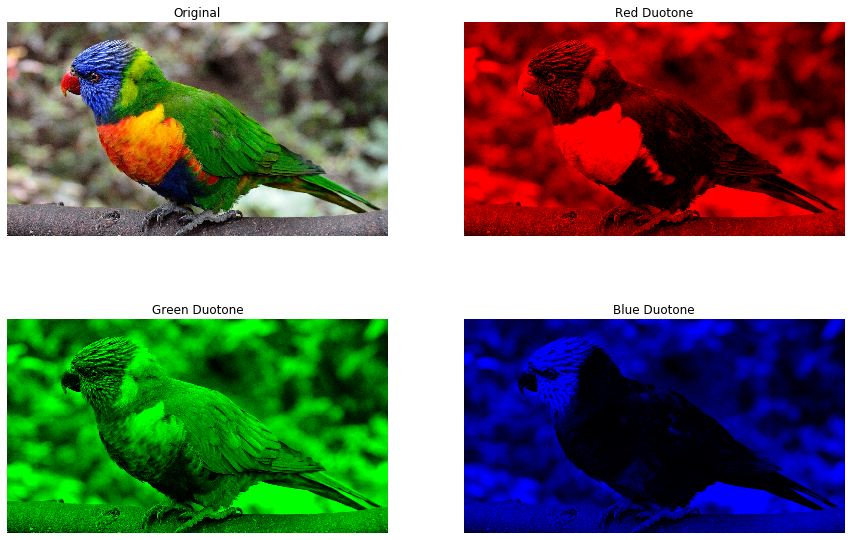

In [28]:
fig1, axes1 = plt.subplots(2,2, figsize = (15,10))

p = 1.05

axes1[0][0].imshow(parrot)
axes1[0][0].axis('off')
axes1[0][0].set_title('Original')

axes1[0][1].imshow(duotone(parrot, 0, p))
axes1[0][1].axis('off')
axes1[0][1].set_title('Red Duotone')

axes1[1][0].imshow(duotone(parrot, 1, p))
axes1[1][0].axis('off')
axes1[1][0].set_title('Green Duotone')

axes1[1][1].imshow(duotone(parrot, 2, p))
axes1[1][1].axis('off')
axes1[1][1].set_title('Blue Duotone')

plt.show()

---

# 2

__1. Find the cell organs of interest in the image cell.png. Use the same
code to show your outputs on flower.jpeg.__

In [29]:
def thresholding(im, thresh):
    out = im.copy()
    out[im > thresh] = 255
    out[im <= thresh] = 0
    return out

In [30]:
def floodfill_and_count(bin_img):
    visited = np.zeros(bin_img.shape[0:2])
    return floodfill_and_count_custom(bin_img, visited)

def floodfill_and_count_custom(bin_img, visited, check_value = 255, visited_value = 0):
    img = np.copy(bin_img).astype(int)
    color = 1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == check_value and visited[i,j] == visited_value:
                floodfill(img, color, i, j, visited, check_value = check_value, visited_value = visited_value)
                color += 1
#                 plt.imshow(img, cmap = 'gray')
#                 plt.show()
                
    uni = np.unique(img)
    if 0 in uni:
        count = len(uni) - 1
    else:
        count = len(uni)
    return (img, count)
    
def floodfill(img, color, h, w, visited, out_img = None, check_value = 255, visited_value = 0):
    if out_img is None:
        out_img = img
    queue = [(h,w)]
    out_img[h,w] = color
    dir_x = [1, 0, -1, 0]
    dir_y = [0, -1, 0, 1]
    count_pixels = 0
    visited[h,w] = 1 - visited_value
    while len(queue) > 0:
        x,y = queue.pop(0)
        count_pixels += 1
        for i in range(len(dir_x)):
            curr_x, curr_y = x + dir_x[i], y + dir_y[i]
            if isValid(img, curr_x, curr_y, visited, check_value, visited_value):
                queue.append((curr_x, curr_y))
                out_img[curr_x, curr_y] = color
                visited[curr_x, curr_y] = 1 - visited_value
    return count_pixels

def isValid(img, i, j, visited, check_value, visited_value):
    return (i >= 0 and i < img.shape[0] and j < img.shape[1] and j >= 0 and img[i,j] == check_value and visited[i,j] == visited_value)

In [31]:
np.zeros((5,5)) is None

False

In [32]:
def fill_color(gray):
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255],
                       [255,20,147], [186,85,211], [124,185,232], [196,98,16]])
    c = len(colors)
    h,w = gray.shape
    out = np.zeros((h,w,3), dtype = "uint8")
    
    for i in range(h):
        for j in range(w):
            if gray[i,j] > 0 and gray[i,j] < 255:
                color = colors[(gray[i,j] % c)]
                out[i,j,0] = color[0]
                out[i,j,1] = color[1]
                out[i,j,2] = color[2]
            elif gray[i,j] == 255:
                out[i,j,0] = 255
                out[i,j,1] = 255
                out[i,j,2] = 255
    return out

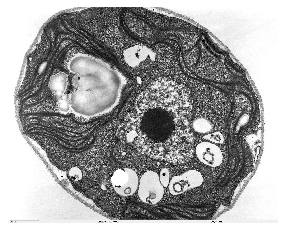

In [33]:
cell_image = np.pad(readGrayImage("cell.png"), ((3,3)), 'constant', constant_values = 255)
plt.imshow(cell_image, cmap = 'gray')
plt.axis("off")
plt.show()

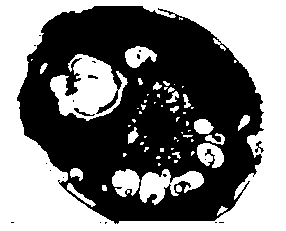

In [34]:
regions_img = thresholding(cv2.blur(cell_image, (3,3)), 150)
regions_img = cv2.morphologyEx(regions_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)))
regions_img = cv2.morphologyEx(regions_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
regions_img = cv2.erode(regions_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2)), iterations = 5)
regions_img = cv2.dilate(regions_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2)), iterations = 5)
plt.imshow(regions_img, cmap = 'gray')
plt.axis("off")
plt.show()

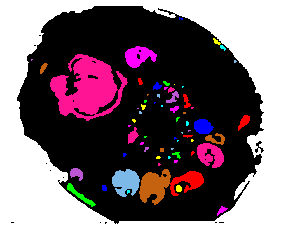

65

In [35]:
regions_interest, count = floodfill_and_count(regions_img)
regions_interest[regions_interest == 1] = 255
plt.imshow(fill_color(regions_interest))
plt.axis("off")
plt.show()
count

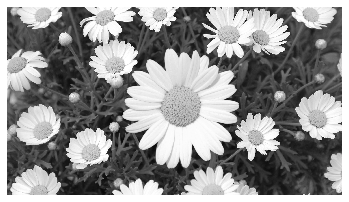

In [36]:
flowers_image = readGrayImage("flower.jpeg")
plt.imshow(flowers_image, cmap = 'gray')
plt.axis("off")
plt.show()

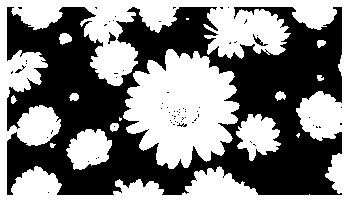

In [37]:
regions_img = thresholding(cv2.blur(flowers_image, (3,3)), 150)
regions_img = cv2.morphologyEx(regions_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)))
regions_img = cv2.morphologyEx(regions_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
regions_img = cv2.erode(regions_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2)), iterations = 5)
regions_img = cv2.dilate(regions_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2)), iterations = 5)
plt.imshow(regions_img, cmap = 'gray')
plt.axis("off")
plt.show()

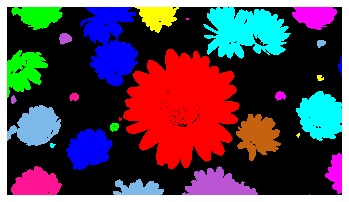

In [38]:
flowers = floodfill_and_count(regions_img)[0]
plt.imshow(fill_color(flowers))
plt.axis("off")
plt.show()

__2. Read in the binary image objects.png and write a script which uses
the image as input and answers the following questions.__

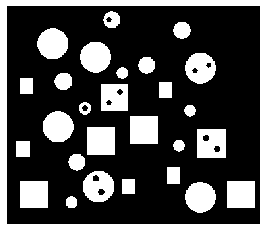

array([  0, 255], dtype=uint8)

In [39]:
objects_image = readGrayImage("objects.png")
plt.imshow(objects_image, cmap = 'gray')
plt.axis("off")
plt.show()
np.unique(objects_image)

In [40]:
# objects_image

__(a) How many objects have one or more holes?__

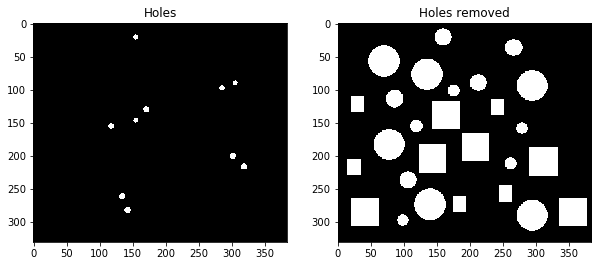

In [41]:
holes = objects_image.copy() / 255
core_objects = np.zeros(holes.shape)
floodfill(holes, 1, 0, 0, core_objects, check_value = 0)
fig, axes = plt.subplots(1,2, figsize = (10,10))
holes = 1-holes
axes[0].imshow(holes, cmap = 'gray')
axes[0].set_title("Holes")

core_objects = 1 - core_objects
axes[1].imshow(core_objects, cmap = 'gray')
axes[1].set_title("Holes removed")

plt.show()

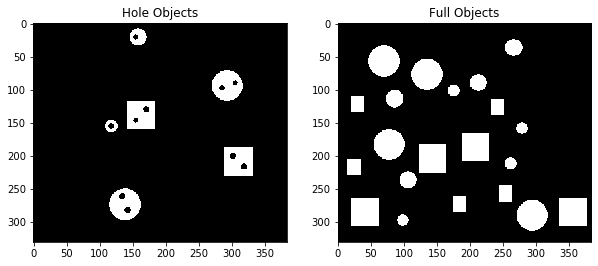

No. of objects with one or more holes = 6
No. of objects with no holes = 21


In [42]:
holes_boundary = cv2.dilate(holes, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))) - holes
full_objects = objects_image.copy()
holes_objects = np.zeros(holes_boundary.shape, "uint8")

for i in range(holes_boundary.shape[0]):
    for j in range(holes_boundary.shape[1]):
        if holes_boundary[i,j] == 1:
            floodfill(full_objects, 0, i, j, holes_objects)

fig, axes = plt.subplots(1,2, figsize = (10,10))
axes[0].imshow(holes_objects, cmap = 'gray')
axes[0].set_title("Hole Objects")

axes[1].imshow(full_objects, cmap = 'gray')
axes[1].set_title("Full Objects")

plt.show()
print("No. of objects with one or more holes =", floodfill_and_count(holes_objects * 255)[1])
print("No. of objects with no holes =", floodfill_and_count(full_objects)[1])

__(b) How many square objects are in the image?__

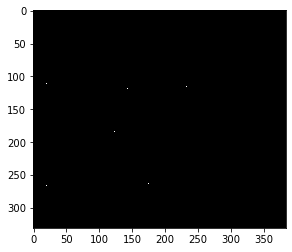

In [43]:
corner_kernel = np.zeros((3,3), "uint8")
corner_kernel[0] = 1
corner_kernel[:,0] = 1
# bottom_left_corner
boundaries = objects_image - cv2.erode(objects_image, corner_kernel, iterations = 1)
squares_corners = cv2.erode(boundaries, corner_kernel, iterations = 1)
squares_corners = np.bitwise_and(squares_corners, objects_image)
plt.imshow(squares_corners, cmap = 'gray')
# np.unique(squares_corners)
# floodfill_and_count(squares_corners)

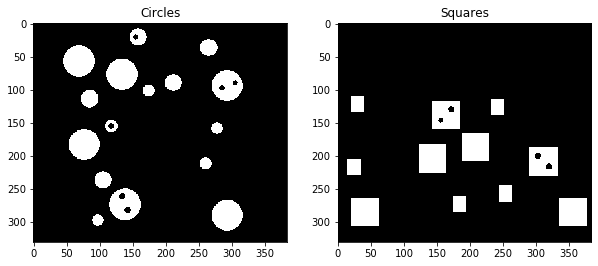

No. of circular objects = 16
No. of square objects = 11


In [44]:
circles = objects_image.copy()
squares = np.zeros(objects_image.shape, "uint8")

for i in range(squares_corners.shape[0]):
    for j in range(squares_corners.shape[1]):
        if squares_corners[i,j] == 255:
            floodfill(circles, 0, i, j, squares)

fig, axes = plt.subplots(1,2, figsize = (10,10))
axes[0].imshow(circles, cmap = 'gray')
axes[0].set_title("Circles")

axes[1].imshow(squares, cmap = 'gray')
axes[1].set_title("Squares")

plt.show()
print("No. of circular objects =", floodfill_and_count(circles)[1])
print("No. of square objects =", floodfill_and_count(squares * 255)[1])

__(c) Identify the square objects that have holes.__

No. of square objects that have holes = 2


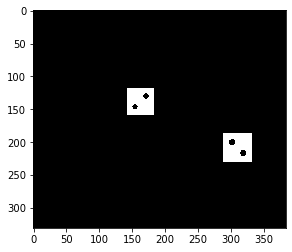

In [45]:
holed_squares = np.bitwise_and(squares*255, holes_objects) * 255
plt.imshow(holed_squares, cmap = 'gray')
print("No. of square objects that have holes =", floodfill_and_count(holed_squares)[1])

__(d) Identify the circular objects that have no holes__

No. of circular objects that have no holes = 12


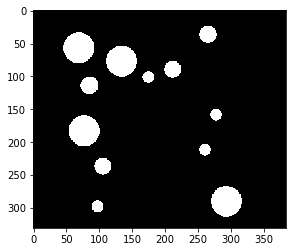

In [46]:
full_circles = np.bitwise_and(circles, full_objects)
plt.imshow(full_circles, cmap = 'gray')
print("No. of circular objects that have no holes =", floodfill_and_count(full_circles)[1])

__3. Read in the binary image circles.jpg and write a script which uses
the image as input and outputs a new image containing
<br>(a) only the coins touching the boundary of the image__

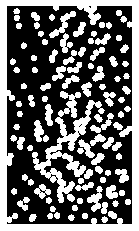

In [47]:
circles_image = thresholding(readGrayImage("circles.jpg"), 127)
plt.imshow(circles_image, cmap = 'gray')
plt.axis("off")
plt.show()

In [48]:
def boundary_circles(img):
    visited = np.zeros(img.shape)
    color = 255
    for i in range(img.shape[0]):
        if img[i,0]:
            floodfill(img, color, i, 0, visited)
        if img[i, img.shape[1]-1] == 255:
            floodfill(img, color, i, img.shape[1]-1, visited)
        
    for i in range(img.shape[1]):
        if img[img.shape[0]-1, i] == 255:
            floodfill(img, color, 0,i, visited)
        if img[0, i] == 255:
            floodfill(img, color, img.shape[0]-1, i, visited)
      
    visited[visited == 1] = 255
    return visited

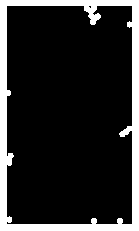

In [49]:
plt.imshow(boundary_circles(circles_image), cmap = 'gray')
plt.axis("off")
plt.show()

__(b) only the coins which overlap with each other__

In [50]:
def overlapping_circles(img):
    visited = np.zeros(img.shape)
    out = np.zeros(img.shape)
    color = 255

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == 255 and visited[i, j] == 0:
                if floodfill(img, color, i, j, visited) > 420:
                    floodfill(img, color, i, j, out)

    out[out == 1] = 255
    return out

In [51]:
# np.sum(np.ones((5,5)) == 1)

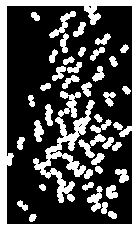

In [52]:
overlapping = overlapping_circles(circles_image)
plt.imshow(overlapping, cmap = 'gray')
plt.axis("off")
plt.show()

__(c) only non-overlapping coins__

In [53]:
def non_overlapping_circles(img):
    visited = np.zeros(img.shape)
    out = np.zeros(img.shape)
    color = 255

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == 255 and visited[i, j] == 0:
                if floodfill(img, color, i, j, visited) <= 420:
                    floodfill(img, color, i, j, out)

    out[out == 1] = 255
    return out

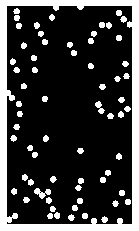

In [54]:
non_overlapping = circles_image - overlapping
# non_overlapping = non_overlapping_circles(circles_image)
plt.imshow(non_overlapping, cmap = 'gray')
plt.axis("off")
plt.show()

---

# 3 

__1. Thresholding
<br>(a) Show the results on multiple threshold values. Use morphological methods
to fill gaps in the thresholded image and obtain the number of coins without
manually counting.__

In [55]:
# a = np.arange(49).reshape((7,7))
# a[np.where((a>7) & (a < 14))] = 255
# a[np.where((a>=21) & (a <= 25))] = 255
# a[np.where((a>=41) & (a <= 49))] = 255
# a[a<255] = 0
# 0 in np.unique(a)
# floodfill_and_count(a)

In [56]:
# np.unique(np.array([1,2,2,3]))

In [57]:
coins_img = readGrayImage("coins.png")

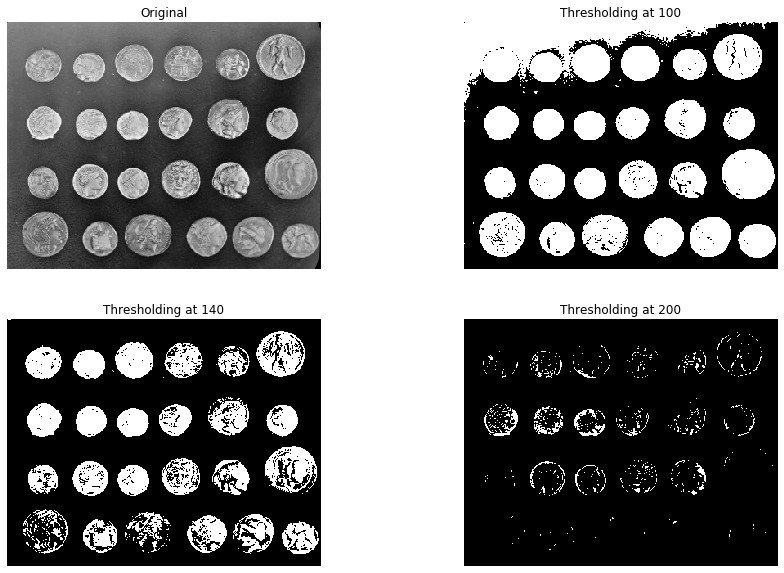

In [58]:
fig1, axes1 = plt.subplots(2,2, figsize = (15,10))

axes1[0][0].imshow(coins_img, cmap = 'gray')
axes1[0][0].axis('off')
axes1[0][0].set_title('Original')

thresh = 100
coins_thresh = thresholding(coins_img, thresh)
axes1[0][1].imshow(coins_thresh, cmap = 'gray')
axes1[0][1].axis('off')
axes1[0][1].set_title(f"Thresholding at {thresh}")

thresh = 140
coins_thresh = thresholding(coins_img, thresh)
axes1[1][0].imshow(coins_thresh, cmap = 'gray')
axes1[1][0].axis('off')
axes1[1][0].set_title(f"Thresholding at {thresh}")

thresh = 200
coins_thresh = thresholding(coins_img, thresh)
axes1[1][1].imshow(coins_thresh, cmap = 'gray')
axes1[1][1].axis('off')
axes1[1][1].set_title(f"Thresholding at {thresh}")

plt.show()

Threshold of 140 seems to be the most suited

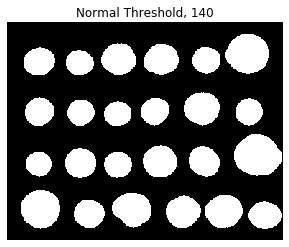

No of coins = 24


In [59]:
thresh = 140
coins_thresh = thresholding(coins_img, thresh)
count_img = cv2.morphologyEx(coins_thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19)))
count_img = cv2.morphologyEx(count_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31)))
plt.imshow(count_img, cmap = 'gray')
plt.title(f"Normal Threshold, {thresh}")
plt.axis("off")
plt.show()
# thresh
print("No of coins =", floodfill_and_count(count_img)[1])

__(b) Implement Otsu’s thresholding and then perform the counting. Compare
your results with (a).__

In [60]:
def otsu_thresh(img, is_normalized = True):
    hist, bin_edges = np.histogram(img, bins = 256)
    if is_normalized:
        hist = np.divide(hist.ravel(), hist.max())

    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    w1 = np.cumsum(hist)
    w2 = np.cumsum(hist[::-1])[::-1]

    m1 = np.cumsum(hist * bin_mids) / w1
    m2 = (np.cumsum((hist * bin_mids)[::-1]) / w2[::-1])[::-1]

    variance_inter = w1[:-1] * w2[1:] * (m1[:-1] - m2[1:]) ** 2
    max_val_index = np.argmax(variance_inter)
    thresh = bin_mids[:-1][max_val_index]
    
    return (thresholding(img, thresh), thresh)

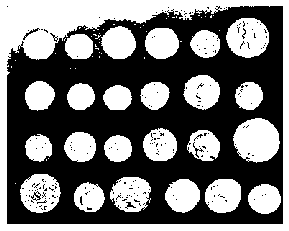

106.400390625

In [61]:
coins_otsu, thresh = otsu_thresh(coins_img)
# coins_otsu = otsu_thresh(coins_img)
plt.imshow(coins_otsu, cmap = 'gray')
plt.axis("off")
plt.show()
thresh

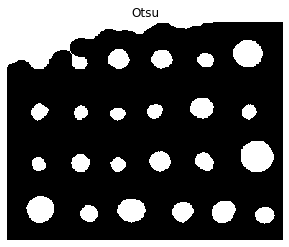

No of coins = 24


In [62]:
count_img = cv2.morphologyEx(coins_otsu, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
count_img = cv2.morphologyEx(count_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15)))
count_img = cv2.morphologyEx(count_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21)))
count_img = cv2.erode(count_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18,18)), iterations = 1)

plt.imshow(count_img, cmap = 'gray')
plt.axis("off")
plt.title("Otsu")
plt.show()
print("No of coins =", floodfill_and_count(count_img)[1])

__2. Edge-based segmentation : Show the results by using different detection methods like sobel, canny and laplacian to detect the edges and further use morphological
methods to obtain segmented image.__

In [63]:
def apply_kernel_single(img, kernel, new_channel_shape):
    new_img = np.zeros(new_channel_shape, np.int)
    for i in range(new_channel_shape[0]):
        for j in range(new_channel_shape[1]):
            new_img[i][j] = np.round(np.sum(img[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel))
    return new_img

def apply_kernel(img, kernel, zero_padding = 0):
    in_img = np.zeros((img.shape[0] + 2 * zero_padding, img.shape[1] + 2 * zero_padding), int)
    in_img[zero_padding : in_img.shape[0] - zero_padding, zero_padding : in_img.shape[1] - zero_padding] = img
    
    new_h, new_w = in_img.shape[0] - kernel.shape[0] + 1, in_img.shape[1] - kernel.shape[1] + 1
    
    if len(img.shape) == 2:
        return apply_kernel_single(in_img, kernel, (new_h, new_w))
        
    new_img = np.zeros((new_h, new_w, img.shape[2]), np.int)
    for c in range(img.shape[2]):
        new_img[:,:,c] = apply_kernel_single(in_img[:,:,c], kernel, (new_h, new_w))
    return new_img

In [64]:
def sobel_filter(img, direction = 'x', zero_padding = 0):
    if (direction == 'x'):
        Mx = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])
        return apply_kernel(img, Mx, zero_padding).astype("uint8")
    if (direction == 'y'):
        My = np.array([[1, 2, 1],
                       [0, 0, 0],
                       [-1,-2,-1]])
        return apply_kernel(img, My, zero_padding).astype("uint8")
    
    Mx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    My = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1,-2,-1]])
    return np.sqrt(apply_kernel(img, Mx,zero_padding) ** 2 + apply_kernel(img, My, zero_padding) ** 2).astype("uint8")

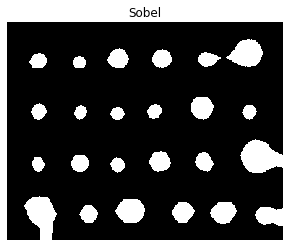

No of coins = 24


In [65]:
sobel_coins = sobel_filter(coins_img, 'xy')
sobel_coins = thresholding(sobel_coins, 75)
sobel_coins = cv2.morphologyEx(sobel_coins, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15)))
sobel_coins = cv2.morphologyEx(sobel_coins, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35,35)))
sobel_coins = cv2.erode(sobel_coins, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 5)
# sobel_coins = thresholding(sobel_coins, 75)
plt.imshow(sobel_coins,cmap = 'gray')
plt.axis("off")
plt.title("Sobel")
plt.show()
print("No of coins =", floodfill_and_count(sobel_coins)[1])

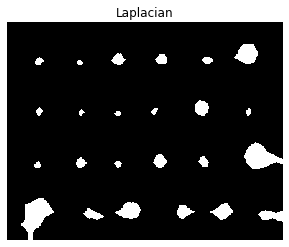

No of coins = 24


In [66]:
blur = cv2.GaussianBlur(coins_img,(3,3),0)
laplacian_coins = cv2.Laplacian(blur,cv2.CV_8UC1)
laplacian_coins = thresholding(laplacian_coins, 10)
laplacian_coins = cv2.morphologyEx(laplacian_coins, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17,17)))
laplacian_coins = cv2.morphologyEx(laplacian_coins, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31)))
laplacian_coins = cv2.erode(laplacian_coins, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 8)
plt.imshow(laplacian_coins, cmap = 'gray')
plt.axis("off")
plt.title("Laplacian")
plt.show()
print("No of coins =", floodfill_and_count(laplacian_coins)[1])

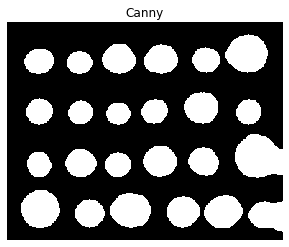

No of coins = 24


In [67]:
canny_coins = cv2.Canny(coins_img, 100,200)
canny_coins = cv2.morphologyEx(canny_coins, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21)))
canny_coins = cv2.morphologyEx(canny_coins, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35,35)))
canny_coins = cv2.erode(canny_coins, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
plt.imshow(canny_coins, cmap = 'gray')
plt.axis("off")
plt.title("Canny")
plt.show()
print("No of coins =", floodfill_and_count(canny_coins)[1])

__3. Compare and analyse the results obtained from the above segmentation methods.__

Managed to get the right number of coins after applying morphological operations on normal thresholding, Otsu's thresholding, Canny, Laplacian and Sobel results. Best looking results are obtained from normal thresholding then Canny. Sobel does a decent job too, but the coins needed to be eroded a lot, same with Laplacian. Otsu's did the worse.
<br>Outputs compared - Normal Thresh > Canny > Sobel > Laplacian ~ Otsu
<br>Otsu is not giving a good output due to illumination issues.

---

# 4

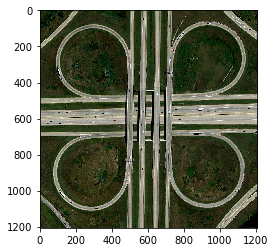

In [68]:
road_gray = readGrayImage("roads.jpg")
road_img = readRgbImage("roads.jpg")
# plt.figure(figsize  = (10,10))
plt.imshow(road_img)

__1. Show the outline of the vertically oriented middle carriageways which are not connected to the circle like interchanges.__

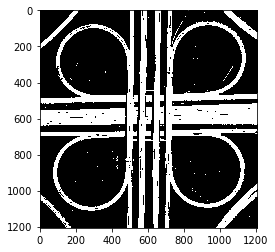

In [69]:
road_otsu = otsu_thresh(road_gray)[0]
# plt.figure(figsize  = (10,10))
plt.imshow(road_otsu, cmap = 'gray')

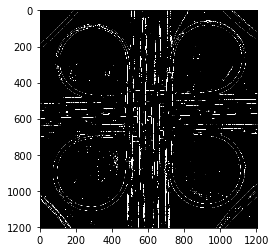

In [70]:
# blurred_roads = cv2.blur(road_gray, (3,3))
edges_road = sobel_filter(road_otsu, 'xy')
plt.imshow(edges_road, cmap = 'gray')

In [71]:
def houghLines(img, del_r, del_theta, thresh, default = 1):
    if default == 0:
        r_dim = np.sqrt(img.shape[0]**2 + img.shape[1]**2) / del_r
        theta_dim = 2 * np.pi / del_theta
        hough_accumulator = np.zeros((r_dim,theta_dim))
        for x in range(x_max):
            for y in range(y_max):
                if img[x,y] < 255:
                    for itheta in range(theta_dim):
                        theta = 1.0 * itheta * theta_max / theta_dim
                        r = x * math.cos(theta) + y * math.sin(theta)
                        ir = int(r_dim * ( 1.0 * r ) / r_max)
                        hough_accumulator[ir,itheta] = hough_accumulator[ir,itheta] + 1
        return np.argwhere(hough_accumulator >= thresh)
    elif default == 1:
        return cv2.HoughLines(img, del_r, del_theta, thresh)
    else:
        return cv2.HoughLinesP(img, del_r, del_theta, thresh)

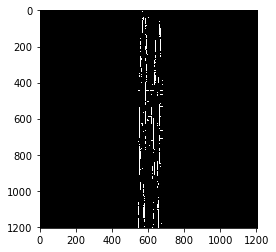

In [72]:
edges_otsu = thresholding(edges_road, 50)
edges_otsu[:, :540] = 0
edges_otsu[:, 680:] = 0
plt.imshow(edges_otsu, cmap = 'gray')
# otsu_thresh(edges_road)[1]

(50, 1, 2)

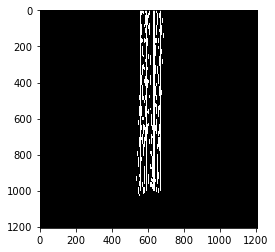

In [73]:
img = np.zeros(road_otsu.shape[0:2], np.uint8)
lines = houghLines(edges_otsu, 1, np.pi/180, 200, 1)

for i in range(len(lines)):
        r,theta = lines[i,0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0, y0 = a*r, b*r
        x1, y1 = int(x0 + 1000*(-b)), int(y0 + 1000*(a))
        x2, y2 = int(x0 - 1000*(-b)), int(y0 - 1000*(a))

        cv2.line(img,(x1,y1), (x2,y2), (255), 1)
plt.imshow(img, cmap = 'gray')
lines.shape

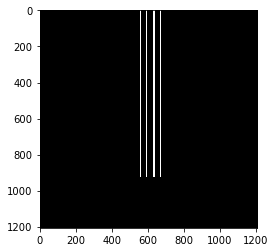

In [74]:
output = cv2.erode(img, np.ones((150,1)))
plt.imshow(output, cmap='gray')

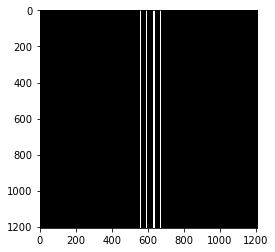

In [75]:
out_new = np.zeros(output.shape[0:2])
new_lines = houghLines(output, 1, np.pi/180, 500, 2)
for i in range(new_lines.shape[0]):
    x1, y1, x2, y2 = new_lines[i, 0]
    y1 = output.shape[1]-1
    cv2.line(out_new, (x1, y1), (x2, y2), (255), 1)
plt.imshow(out_new, cmap = 'gray')
plt.show()

In [76]:
# line_road = cv2.erode(img, np.ones((50,1)))
# # line_road[:, :500] = 0
# # line_road[:, 700:] = 0
# line_road = cv2.dilate(line_road, np.ones((900,1)), 1)
# line_road = cv2.erode(line_road, np.ones((1000,1)), 2)
# # line_road = cv2.morphologyEx(line_road, cv2.MORPH_CLOSE, np.ones((500,1)))
# plt.imshow(line_road, cmap = 'gray')

In [77]:
# # otsu_roads = otsu_thresh(edges_road)[0]
# blurred_roads = cv2.blur(road_gray, (5,5))
# edges_road = sobel_filter(blurred_roads, 'xy')
# plt.imshow(edges_road, cmap = 'gray')
# plt.show()
# cropped = thresholding(edges_road, 100)

# # out = cv2.dilate(cropped, cv2.getStructuringElement(cv2.MORPH_RECT, (21,1)))
# plt.imshow(cropped, cmap = 'gray')
# plt.show()

__2. Display the best fitting circle for each of the circle-like interchanges and output the
radius of each in pixels.__

In [78]:
from collections import defaultdict

def hough_circles(img, radius_range, num_thetas, del_r = 1, bin_threshold = 0.4, default = 1):
    if default == 1:
        return cv2.HoughCircles(road_blur, cv2.HOUGH_GRADIENT, 1, img.shape[0]/del_r, param1=200, param2=10, 
                                minRadius=radius_range[0], maxRadius=radius_range[1])
    
    h, w = img.shape[:2]
    del_theta = int(360 / num_thetas)
    theta_vals = np.arange(0, 360, del_theta)
    radius_vals = np.arange(radius_range[0], radius_range[1], del_r)

    cos_t = np.cos(np.deg2rad(theta_vals))
    sin_t = np.sin(np.deg2rad(theta_vals))
    
    circles = []
    for r in radius_vals:
        for t in range(num_thetas):
            circles.append((r, int(r * cos_t[t]), int(r * sin_t[t])))
            
    accumulator = defaultdict(int)
  
    for i in range(h):
        for j in range(w):
            if img[i,j] != 0:
                for r, rcos_t, rsin_t in circles:
                    x_center = j - rcos_t
                    y_center = i - rsin_t
                    accumulator[(x_center, y_center, r)] += 1
  
    output_img = img.copy()
    out_circles = []
        
    for candidate, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
        x, y, r = candidate
        curr_vote_percent = votes / num_thetas
        if curr_vote_percent >= bin_threshold: 
            out_circles.append((x, y, r, current_vote_percentage))
            print(x, y, r, current_vote_percentage)
    return out_circles


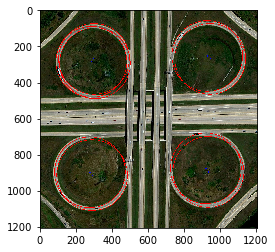

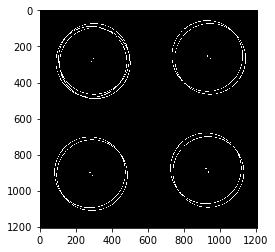

In [79]:
road_img = readRgbImage("roads.jpg")
road_blur = cv2.medianBlur(road_gray, 5)

# circles = cv2.HoughCircles(road_blur, cv2.HOUGH_GRADIENT, 1, road_blur.shape[0]/64, param1=200, param2=10, minRadius=195, maxRadius=196)
circles = hough_circles(road_blur, (196,197),180, 64)

circles_img = np.zeros(road_img.shape[0:2], np.uint8)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circl
        cv2.circle(road_img, (i[0], i[1]), i[2], (255, 0, 0), 2)
        cv2.circle(circles_img, (i[0], i[1]), i[2], (255), 2)
        
        # Draw inner circle
        cv2.circle(road_img, (i[0], i[1]), 2, (0, 0, 255), 3)
        cv2.circle(circles_img, (i[0], i[1]), 2, (255), 3)
        
plt.imshow(road_img)
plt.show()
plt.imshow(circles_img, cmap = 'gray')
plt.show()

Radius = 195

__3. Segment all the large trailer trucks visible in the picture. (Hint : Select the seeds
in side the trucks, use region growing to segment those trucks)__

In [80]:
road_truck = cv2.GaussianBlur(road_gray, (7,7), 2)
road_truck = sobel_filter(road_truck, 'xy')

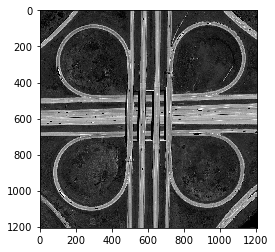

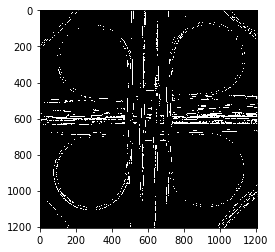

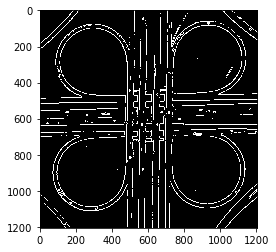

In [81]:
# plt.figure(figsize  = (10,10))
plt.imshow(road_gray, cmap = 'gray')
plt.show()

# plt.figure(figsize  = (10,10))
plt.imshow(thresholding(road_gray,175), cmap = 'gray')
plt.show()

# plt.figure(figsize  = (10,10))
plt.imshow(thresholding(road_truck,100), cmap = 'gray')
plt.show()

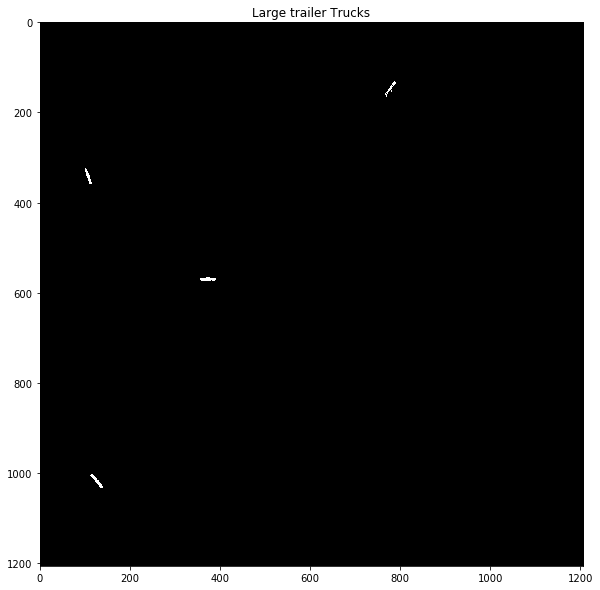

In [82]:
trucks_img = np.zeros(road_gray.shape)
thresh_road = thresholding(road_gray,175)

# visited = np.zeros(road_gray.shape)
floodfill(thresh_road, 255, 344, 106, trucks_img, check_value = 255, visited_value = 0)
floodfill(thresh_road, 255, 1019, 125, trucks_img, check_value = 255, visited_value = 0)
floodfill(thresh_road, 255, 148, 776, trucks_img, check_value = 255, visited_value = 0)
floodfill(thresh_road, 255, 572, 362, trucks_img, check_value = 255, visited_value = 0)

plt.figure(figsize = (10,10))
plt.imshow(trucks_img, cmap = 'gray')
plt.title("Large trailer Trucks")
plt.show()

---

# 5

In [83]:
shinchan_blur = readRgbImage("shinchan_blur.png")
shinchan_b_gray = readGrayImage("shinchan_blur.png")

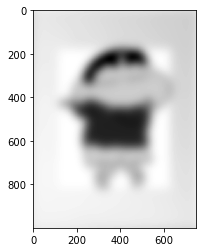

In [84]:
plt.imshow(shinchan_b_gray, cmap = 'gray')

__1. Write a program that creates an array, of the same size as the photo, sampled from
Gaussian point spread function (psf ) f(x,y) with σ of your own choice. Display
this array, remember that the point spread function is periodic (along both axes),
which means that the values for negative x and y are repeated at the end of the
interval. Since the Gaussian is centered on the origin, this means there should be
bright patches in each of the four corners of your picture.__

In [85]:
def psf(img_shape, sigma):
    c_h, c_w = (img_shape[0]-1)//2, (img_shape[1]-1)//2
    out = np.fromfunction(lambda i, j: (i-c_h)**2 + (j-c_w)**2, img_shape[0:2])
    out /= (2 * sigma**2)
    out = np.exp(-out) / (2 * np.pi * sigma**2)
#     out /= np.sum(out)
    return out

In [86]:
# def psf1(img_shape, sigma):
#     h, w = img_shape[0:2]
#     kernel_x = cv2.getGaussianKernel(w, sigma)
#     kernel_y = cv2.getGaussianKernel(h, sigma)
#     kernel = kernel_y * kernel_x.T
# #     kernel = kernel / np.sum(kernel)
#     return kernel

In [87]:
# sigma = 200
# np.allclose(psf1(shinchan_blur.shape, sigma), psf1(shinchan_blur.shape, sigma))

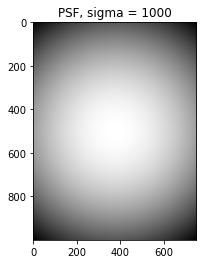

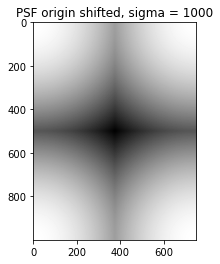

In [88]:
sigma = 1000
psf_shin = psf(shinchan_blur.shape, sigma)
plt.imshow(psf_shin, cmap = 'gray')
plt.title(f"PSF, sigma = {sigma}")
plt.show()
plt.imshow(np.fft.fftshift(psf_shin), cmap = 'gray')
plt.title(f"PSF origin shifted, sigma = {sigma}")
plt.show()

In [89]:
# psf_contrast = linContrastStretchingSingleChannel(psf_shin, 0, 255).astype("uint8")
# plt.imshow(psf_contrast, cmap = 'gray')
# plt.show()
# plt.imshow(np.fft.fft2(np.fft.fftshift(psf_contrast)).real, cmap = 'gray')
# plt.title(f"PSF origin shifted, sigma = {sigma}")
# plt.show()

__2. Deconvolute the blurred image with psf calculated above. (Hint : To get the blurred
image, we convolute the focused image with the psf to blurred image. Use fourier
transform to deconvolute.)
<br>(a) Calculate the Fourier Transforms of Blurred image and psf.__

In [90]:
blur_fft = np.fft.fft2(shinchan_b_gray)
psf_fft = np.fft.fftshift((np.fft.fft2(psf_shin)))

__(b) Divide Fourier Transform of Blurred image with the Fourier Transform of psf.__

In [91]:
out_fft = blur_fft / psf_fft

__(c) Perform Inverse fourier transform.__

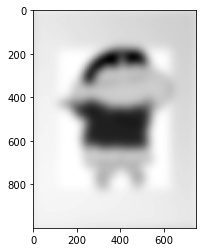

In [92]:
plt.imshow(np.fft.ifft2(out_fft).real, cmap = 'gray')

__3. Try the deconvolution of blurred image with psf for various values of σ.__

In [93]:
def deconvolution(img, sigma):
    psfi = psf(img.shape, sigma)
    img_fft = (np.fft.fft2(img))
    psf_fft = np.fft.fftshift(np.fft.fft2(psfi))
    out_fft = img_fft / psf_fft
    return np.fft.ifft2(out_fft).real

__4. Display the your results for the σ that deblurred the best.__

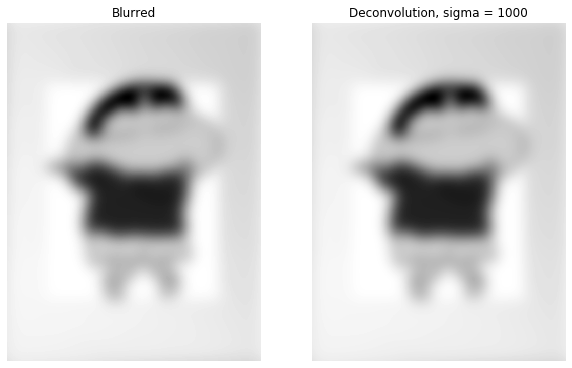

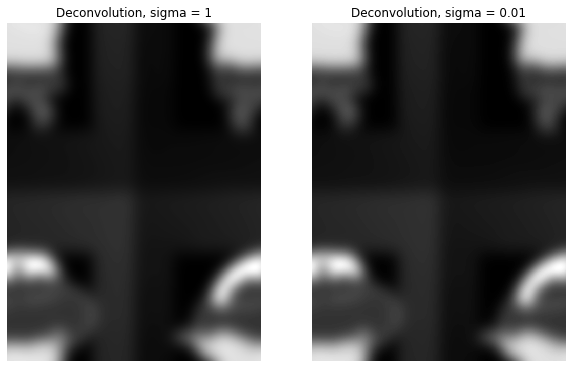

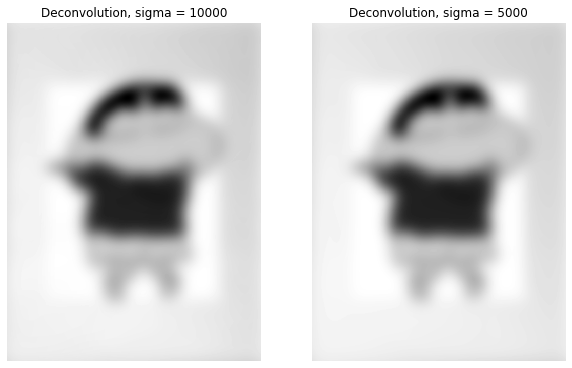

In [94]:
fig1, axes1 = plt.subplots(1,2, figsize = (10,10))
axes1[0].imshow(shinchan_b_gray, cmap = 'gray')
axes1[0].axis('off')
axes1[0].set_title("Blurred")

sigma = 1000
axes1[1].imshow(deconvolution(shinchan_b_gray, sigma), cmap = 'gray')
axes1[1].axis('off')
axes1[1].set_title(f"Deconvolution, sigma = {sigma}")
plt.show()

sigma = 1
fig1, axes1 = plt.subplots(1,2, figsize = (10,10))
axes1[0].imshow(deconvolution(shinchan_b_gray, sigma), cmap = 'gray')
axes1[0].axis('off')
axes1[0].set_title(f"Deconvolution, sigma = {sigma}")

sigma = 0.01
axes1[1].imshow(deconvolution(shinchan_b_gray, sigma), cmap = 'gray')
axes1[1].axis('off')
axes1[1].set_title(f"Deconvolution, sigma = {sigma}")
plt.show()

sigma = 10000
fig1, axes1 = plt.subplots(1,2, figsize = (10,10))
axes1[0].imshow(deconvolution(shinchan_b_gray, sigma), cmap = 'gray')
axes1[0].axis('off')
axes1[0].set_title(f"Deconvolution, sigma = {sigma}")

sigma = 5000
axes1[1].imshow(deconvolution(shinchan_b_gray, sigma), cmap = 'gray')
axes1[1].axis('off')
axes1[1].set_title(f"Deconvolution, sigma = {sigma}")
plt.show()

No best sigma balue as of now

---

# 6

__1. Help Kalyan to compress the color image using Huffman encoding to share the
image to his friend. You can learn about huffman encoding here.
<br>(a) Create the dictionary of all the letters in the image array.__

In [95]:
# only intensities
def create_dict(img):
    letters, counts = np.unique(shinchan_img, return_counts = True)
    counts = counts / np.sum(counts)
    letters_dict = dict(zip(letters,counts))
    return letters_dict

__<br>(b) Generate the Huffman Tree from the tree generated by considering all the
letters in the dictionary as the leaf nodes. Print the Huffman tree.__

In [96]:
class TreeNode(object):
    def __init__(self, prob = 0, left = None, right = None, letter = -1, binary = None):
        self.prob = prob
        self.left = left
        self.right = right
        self.letter = letter
        self.binary = binary

In [97]:
def sort_nodes_list(node):
    return node.prob

def generate_Huffman_tree(letters_dict):
    nodes_list = []
    for letter in letters_dict:
        nodes_list.append(TreeNode(prob = letters_dict[letter], letter = letter))
        
    while(len(nodes_list) > 1):
        nodes_list.sort(key = sort_nodes_list)
        A = nodes_list.pop(0)
        B = nodes_list.pop(0)
        
        if A.prob >= B.prob:
            nodes_list.append(TreeNode(A.prob + B.prob, A, B))
        else:
            nodes_list.append(TreeNode(A.prob + B.prob, B, A))
            
    return nodes_list[0]

__<br>(c) Assign the code words 0 and 1 to the nodes of the Huffman tree.__

In [98]:
def assign_binary(Huffman_tree):
    if Huffman_tree != None and Huffman_tree.left != None and Huffman_tree.left != None:
        Huffman_tree.left.binary = 0
        Huffman_tree.right.binary = 1
        assign_binary(Huffman_tree.left)
        assign_binary(Huffman_tree.right)
    return

__<br>(d) Generate binary code of the image by the binary representation from the above
tree.__

In [99]:
def generate_letters_code(tree, codes_dict, curr_code = ""):
    if tree == None:
        return
    
    if tree.binary == None:
        generate_letters_code(tree.left, codes_dict, curr_code)
        generate_letters_code(tree.right, codes_dict, curr_code)
        return
    
    if tree.letter > -1:
        codes_dict[tree.letter] = curr_code + str(tree.binary)
        return
        
    curr_code = curr_code + str(tree.binary)
    generate_letters_code(tree.left, codes_dict, curr_code)
    generate_letters_code(tree.right, codes_dict, curr_code)
    return

In [100]:
def Huffman_encode(img, letters_dict):
    tree = generate_Huffman_tree(letters_dict)
    assign_binary(tree)
    codes_dict = {}
    generate_letters_code(tree, codes_dict, curr_code = "")
#     str_length = len(max(list(codes_dict.values()), key = len))
    
    out = ""
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(img.shape[2]):
                out += codes_dict[img[i,j,c]]

    return out

__2. Display the image stored in the file shinchan.pkl.__

In [101]:
import json

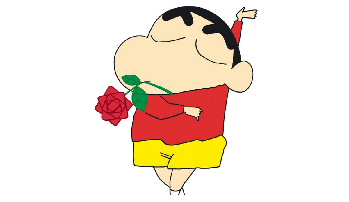

(648, 1152, 4)

In [102]:
shinchan_text = np.load("../images/shinchan.pkl", allow_pickle=True)
shinchan_img = np.array(json.loads(shinchan_text))
plt.imshow(shinchan_img)
plt.axis("off")
plt.show()
shinchan_img.shape

In [103]:
letters_dict = create_dict(shinchan_img)
# len(letters_dict)

In [104]:
# tree = generate_Huffman_tree(letters_dict)
# print(tree)
# print(tree.left)
# print(tree.right)
# print(tree.left.binary)
# print(tree.right.binary)

In [105]:
# assign_binary(tree)
# print(tree)
# print(tree.left)
# print(tree.right)
# print(tree.left.binary)
# print(tree.right.binary)

In [106]:
huffman_code = Huffman_encode(shinchan_img, letters_dict)

In [107]:
# huffman_code

__3. Save the generated binary code of image in compressed.bin. This is supposed to
be less than 10MB in size. He will be sharing this file to his friend.__

In [108]:
file = open("../images/compressed.bin", "wb")
file.write(bytearray(huffman_code.encode('ascii')))
file.close()

__4. Print the size of extracted text from shinchan.pkl and size of compressed.bin in
MB.__

In [109]:
import os
import sys

In [110]:
# path1 = "../images/shinchan.pkl"
# print(f"Size of shinchan.pkl file = {os.path.getsize(path1)/1024/1024} MB")
print(f"Size of extracted text from shinchan.pkl file = {sys.getsizeof(shinchan_text)/1024/1024} MB")

path2 = "../images/compressed.bin"
print(f"Size of compressed.bin file = {os.path.getsize(path2)/1024/1024} MB")

Size of extracted text from shinchan.pkl file = 15.41247272491455 MB
Size of compressed.bin file = 6.599205017089844 MB


__5. Write a function to help his friend decode the original image from compressed.bin
and display it.__

In [111]:
def huffman_decode(input_string, letters_dict, img_shape):
    tree = generate_Huffman_tree(letters_dict)
    assign_binary(tree)
    img_array = []
    helper_tree = tree
    for c in input_string:
        if c == '0' and helper_tree.left:
            helper_tree = helper_tree.left
        elif helper_tree.right:
            helper_tree = helper_tree.right
        
        if helper_tree.left is None and helper_tree.right is None:
            img_array.append(helper_tree.letter)
            helper_tree = tree
            
    return np.array(img_array).reshape(img_shape)

__6. Verify if the image obtained after decoding and the original image are the same.__

In [112]:
file_path = "../images/compressed.bin"
with open(file_path, mode='rb') as file:
    input_string = file.read()
    file.close()
input_string = input_string.decode('utf-8')

decoded_img = huffman_decode(input_string, letters_dict, shinchan_img.shape)
decoded_img.shape

(648, 1152, 4)

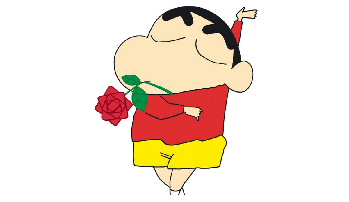

In [113]:
plt.imshow(decoded_img)
plt.axis('off')
plt.show()

In [114]:
(decoded_img == shinchan_img).all()

True

---

In [115]:
# codes_dict = {}
# generate_letters_code(tree, codes_dict, curr_code = "")
# codes_dict
# s = ""
# for v in list(codes_dict.values()):
#     s += v
# a = huffman_decode(s, letters_dict, (-1))
# b = list(codes_dict.keys())
# (np.array(b) == np.array(a)).all()

---